In [1]:
!apt-get -qq install python-cartopy python3-cartopy

Selecting previously unselected package python-pkg-resources.
(Reading database ... 130963 files and directories currently installed.)
Preparing to unpack .../0-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../1-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../2-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../3-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../4-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-pkg-resources.
Preparing to unpack .../5-pyth

In [0]:
import gzip
import random
import time
import warnings

import pandas as pd
import seaborn as sns
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import cartopy.crs as ccrs

from google.colab import drive
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from tqdm import tqdm_notebook
from collections import Counter

warnings.filterwarnings(action='ignore')

pd.set_option("display.max_rows",6)
pd.set_option("display.max_columns",None)
pd.options.mode.chained_assignment = None  # default='warn'

sns.set(style='ticks', color_codes=True, font_scale=1.2)
sns.set_style('darkgrid', {'legend.frameon':True})

%matplotlib inline

# Dataset overview

Вгрузим данные. Будем работать только с таблицей apptrip.csv.

In [3]:
drive.mount('/content/drive')
root_path = 'drive/My Drive'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# zip_ar = ['apptrip.csv.gz', 'flight_global.csv.gz', 'prices-1.csv.gz',  'prices-2.csv.gz']
zip_ar = ['apptrip.csv.gz']
dataframe_ar = []

for file in zip_ar:
  with gzip.open(root_path + '/aita-internship/' + file) as f:
    dataframe_ar.append(pd.read_csv(f))

apptrip_df = dataframe_ar[0]
# flight_global_df = dataframe_ar[1]
# prices1_df = dataframe_ar[2]
# prices2_df = dataframe_ar[3]

Также для дальнейшей визуализации возьмём датасет с координатами городов.

In [5]:
city_coords = None
with open(root_path+'/my_coords/worldcities.csv') as f:
  city_coords = pd.read_csv(f)
display(city_coords)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
...,...,...,...,...,...,...,...,...,...,...,...
12956,Brandon,Brandon,43.5928,-96.5799,United States,US,USA,South Dakota,NaN,9263.0,1840002650
12957,Madison,Madison,44.0062,-97.1084,United States,US,USA,South Dakota,NaN,6983.0,1840002540
12958,Belle Fourche,Belle Fourche,44.6640,-103.8564,United States,US,USA,South Dakota,NaN,5202.0,1840002127


In [0]:
def get_info(df):
  """
  Выдаёт краткую информацию по датасету
  
  Arguments:
  ----------
    df (DataFrame) : Датафрейм pandas с данными для работы
    
  Returns:
  --------
    DataFrame : Датафрейм pandas с краткой информацией
  """
  info = pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
  info = info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values amount'}))
  info = info.append(pd.DataFrame(df.isnull().sum() / df.shape[0] * 100)
                           .T.rename(index={0:'null values percentage'}))
  return info

## apptrip.csv
**user_id** (integer) - уникальный идентификатор пользователя aita

**trip_id** (integer) - уникальный идентификатор trip’a. trip - поездка user’a будь то один рейс, перелет с пересадками или полеты туда-обратно.

**flight_id** (integer) - уникальный идентификатор рейса. Рейс - полет из одного сегмента из А в Б в заданное время

**date** (timestamp) - дата и время вылета (местное)

**km** (integer) - расстояние между аэропортами вылета и прилета

**departure_code** (string) - код аэропорта вылета

**arrival_code** (string) - код аэропорта прилета

**departure_utc** (timestamp) - дата и время вылета (utc)

**arrival_utc** (timestamp) - дата и время прилета (utc)

**carrier** (string) - код авиалинии, от имени которой продавались билеты на рейс (то, что пользователь видел в поисковой выдаче)

**number** (integer) - номер рейса

**arrival_date** (timestamp) дата и время прилета (местное)

**flight_date** (timestamp) - дата вылета (местное)

**carrier_operating** (string) - код авиалинии, которая выполняет рейс

**parent_carrier_operating** (string) - код авиалинии, которая является родительской авиакомпанией для carrier_operating

**city_code_dep** (string) - код города вылета

**city_code_arr** (string) - код города прилета

In [7]:
print(f'apptrip_df shape: {apptrip_df.shape}')
display(get_info(apptrip_df))
display(apptrip_df)

apptrip_df shape: (2346386, 17)


,user_id,trip_id,flight_id,date,km,departure_code,arrival_code,departure_utc,arrival_utc,carrier,number,arrival_date,flight_date,carrier_operating,parent_carrier_operating,city_code_dep,city_code_arr
column type,uint64,uint64,uint64,object,int64,object,object,object,object,object,float64,object,object,object,object,object,object
null values amount,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,43
null values percentage,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00115071,0.00183261


,user_id,trip_id,flight_id,date,km,departure_code,arrival_code,departure_utc,arrival_utc,carrier,number,arrival_date,flight_date,carrier_operating,parent_carrier_operating,city_code_dep,city_code_arr
0,127273452813277031,5019333959813059623,1958600537343904604,2014-12-28 15:13:24,4767293,QQHJL,GKUNQ,2014-12-28 22:13:24,2014-12-29 01:06:24,ZLG,791.0,2014-12-28 17:06:24,2014-12-28 06:32:24,ZLG,ZLG,UREO,PSXW
1,15390893174943840158,106345742811478386,985350630572826792,2015-01-02 15:13:24,4767293,QQHJL,GKUNQ,2015-01-02 22:13:24,2015-01-03 01:06:24,ZLG,791.0,2015-01-02 17:06:24,2015-01-02 06:32:24,ZLG,ZLG,UREO,PSXW
2,18261388016654189117,13369013905641136915,4248497162079901740,2015-04-09 20:13:24,4767293,QQHJL,GKUNQ,2015-04-10 02:13:24,2015-04-10 04:51:24,WDL,5767.0,2015-04-09 21:51:24,2015-04-09 06:32:24,WDL,WDL,UREO,PSXW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346383,10616358703406557904,3064281777888438206,12565269733805024459,2016-05-29 22:07:24,1371458,SFAFX,IOSWI,2016-05-30 02:07:24,2016-05-30 03:27:24,ZLG,2595.0,2016-05-29 23:27:24,2016-05-29 06:32:24,ZLG,ZLG,CTRO,KFPS
2346384,18341274180530324322,1941205719887426295,11526579854601790076,2015-08-12 00:12:24,2060468,OLMIN,IUIPW,2015-08-12 06:12:24,2015-08-12 07:37:24,BZM,2614.0,2015-08-12 01:37:24,2015-08-11 06:32:24,BZM,BZM,WJUM,MNXF
2346385,10616358703406557904,9618271368104549637,16516364872477624091,2016-05-30 15:02:24,1371458,SFAFX,IOSWI,2016-05-30 19:02:24,2016-05-30 20:15:24,ZLG,1435.0,2016-05-30 16:15:24,2016-05-30 06:32:24,ZLG,ZLG,CTRO,KFPS


Преобразуем время из object в datetime, выкинем лишние столбцы и отсортируем таблицу по дате полёта

In [0]:
for col in ['departure_utc', 'arrival_utc']:
  apptrip_df[col] = pd.to_datetime(apptrip_df[col], format='%Y-%m-%d %H:%M:%S')
apptrip_df.drop(['date', 'arrival_date', 'flight_date'], axis=1, inplace=True)

In [9]:
apptrip_sorted_df = apptrip_df.sort_values('departure_utc')
apptrip_sorted_df.reset_index(drop=True, inplace=True)
display(apptrip_sorted_df)

,user_id,trip_id,flight_id,km,departure_code,arrival_code,departure_utc,arrival_utc,carrier,number,carrier_operating,parent_carrier_operating,city_code_dep,city_code_arr
0,16684616740082637648,8370723895543604805,14468557500126604141,13622712,TOAIF,CGAGO,2013-09-04 18:02:24,2013-09-05 00:17:24,EPA,134.0,EPA,ZQR,PAKK,DVMF
1,703906126218602225,1242390668709787571,10354577564753775909,13035413,TOAIF,GKUNQ,2013-12-15 19:32:24,2013-12-16 02:14:24,GWL,124.0,GWL,GWL,PAKK,PSXW
2,13393821774983267280,11402066447776665409,14461502059744627234,12349684,GKUNQ,WJJQS,2013-12-26 21:02:24,2013-12-27 01:59:24,GWL,1420.0,GWL,GWL,PSXW,DHNI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346383,17964607109730452421,10620091609198816224,818609504624860841,14131267,XFXTS,CZVUD,2016-05-31 14:37:24,2016-05-31 20:22:24,ZQR,941.0,ZQR,ZQR,VLVB,ACOK
2346384,9863960447144378872,12524420515508361832,11857684010628150231,13478348,XFXTS,GKUNQ,2016-05-31 14:42:24,2016-05-31 20:02:24,ZVE,127.0,ZVE,PGV,VLVB,PSXW
2346385,5870393595330210248,3047966415762635641,11857684010628150231,13478348,XFXTS,GKUNQ,2016-05-31 14:42:24,2016-05-31 20:02:24,ZVE,127.0,ZVE,PGV,VLVB,PSXW


## Более детальная информация по датасету

Расставим координаты для всех городов и подготовим вспомогательные переменные

In [0]:
cities = pd.unique(apptrip_sorted_df[['city_code_dep', 'city_code_arr']].values.ravel())
coords = random.sample(range(city_coords.shape[0]), cities.shape[0])
coords_tuples = list(map(tuple, city_coords.iloc[coords][['lng', 'lat']].values))

# dict in format {city_code : (lng, lat)}
city_coords_dict = {city: coordinates for city, coordinates in zip(cities, coords_tuples)}

years = apptrip_sorted_df['departure_utc'].map(lambda x: x.year)
year_2014 = apptrip_sorted_df[years == 2014]
year_2014.reset_index(drop=True,inplace=True)
year_2015 = apptrip_sorted_df[years == 2015]
year_2015.reset_index(drop=True,inplace=True)
year_2016 = apptrip_sorted_df[years == 2016]
year_2016.reset_index(drop=True,inplace=True)

months_2014 = year_2014['departure_utc'].map(lambda x: x.month)
months_2015 = year_2015['departure_utc'].map(lambda x: x.month)
months_2016 = year_2016['departure_utc'].map(lambda x: x.month)

Посмотрим общее распределение перелётов в течение всего периода

In [11]:
seasons = ['winter', 'spring', 'summer', 'autumn']
flights_by_year = pd.DataFrame(apptrip_sorted_df['departure_utc'])
flights_by_year['year'] = apptrip_sorted_df['departure_utc'].map(lambda x: x.year)
flights_by_year['month'] = apptrip_sorted_df['departure_utc'].map(lambda x: x.month)
flights_by_year['season'] = flights_by_year['month'].map(lambda x: seasons[(x % 12 + 3) // 3 - 1])
value_counts = pd.DataFrame(flights_by_year.groupby(['year', 'season'])['month'].count())
temp = value_counts.to_dict()['month']
# самая тяжелая строчка на планете
flights_by_year['count'] = flights_by_year[['year', 'season']].apply(lambda x: temp[(x[0], x[1])], axis=1)
display(flights_by_year)

,departure_utc,year,month,season,count
0,2013-09-04 18:02:24,2013,9,autumn,1
1,2013-12-15 19:32:24,2013,12,winter,2
2,2013-12-26 21:02:24,2013,12,winter,2
...,...,...,...,...,...
2346383,2016-05-31 14:37:24,2016,5,spring,290245
2346384,2016-05-31 14:42:24,2016,5,spring,290245
2346385,2016-05-31 14:42:24,2016,5,spring,290245


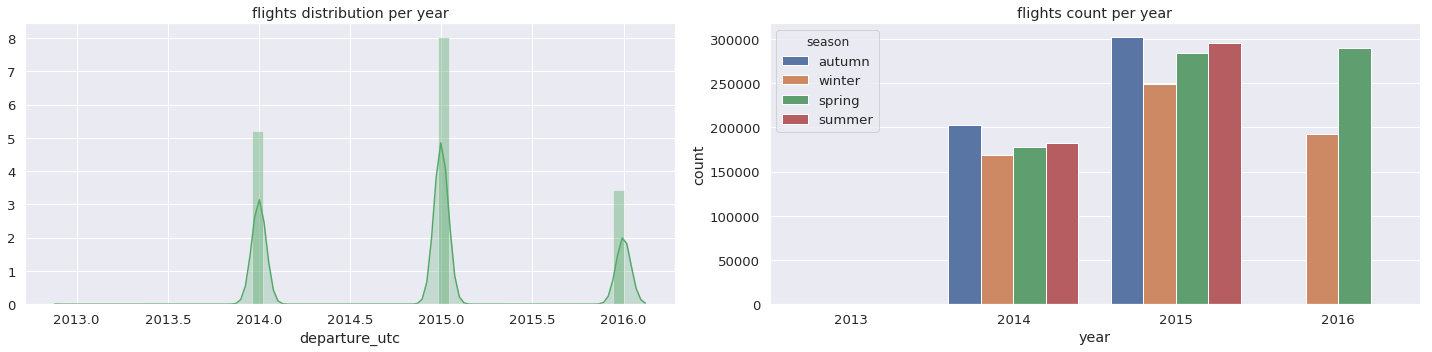

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(20,5))

ax[0].set_title('flights distribution per year')
sns.distplot(years, kde_kws={"shade": True}, color='g', ax=ax[0]);

ax[1].set_title('flights count per year')
sns.barplot(x='year', y='count', data=flights_by_year, hue='season', ax=ax[1])

fig.tight_layout()
plt.savefig(root_path + '/Colab Notebooks/aita_img/img1.png', bbox_inches='tight', pad_inches=1);

Распределение количества trip'ов по годам

In [0]:
def detect_outliers(points, thresh=15.):
  """
  Ищет выбросы в одномерном массиве данных по модифицированному z-score
  
  Arguments:
  ----------
      points (numpy array) : Массив точками, в котором нужно найти выбросы
      thresh (float)       : Порог, по которому будут отсеиваться выбросы
    
  Returns:
  --------
      boolean array : Маска с индикаторами потенциальных выбросов массива
  """
  points = points[:,None]
  median = np.median(points, axis=0)
  diff = np.sum((points - median)**2, axis=-1)
  diff = np.sqrt(diff)
  med_abs_deviation = np.median(diff)

  modified_z_score = 0.6745 * diff / med_abs_deviation
  return modified_z_score > thresh

In [14]:
flights_amount_distribution_2014_wo = year_2014.groupby('user_id')['trip_id'].count()
flights_amount_distribution_2014 = flights_amount_distribution_2014_wo[~detect_outliers(flights_amount_distribution_2014_wo)]

flights_amount_distribution_2015_wo = year_2015.groupby('user_id')['trip_id'].count()
flights_amount_distribution_2015 = flights_amount_distribution_2015_wo[~detect_outliers(flights_amount_distribution_2015_wo)]

flights_amount_distribution_2016_wo = year_2016.groupby('user_id')['trip_id'].count()
flights_amount_distribution_2016 = flights_amount_distribution_2016_wo[~detect_outliers(flights_amount_distribution_2016_wo)]
pd.DataFrame(flights_amount_distribution_2016)

,trip_id
user_id,
46416735145166,2
128772842780841,2
512641917809063,2
...,...
18446069005549468888,1
18446268373573985986,2
18446727674440460311,11


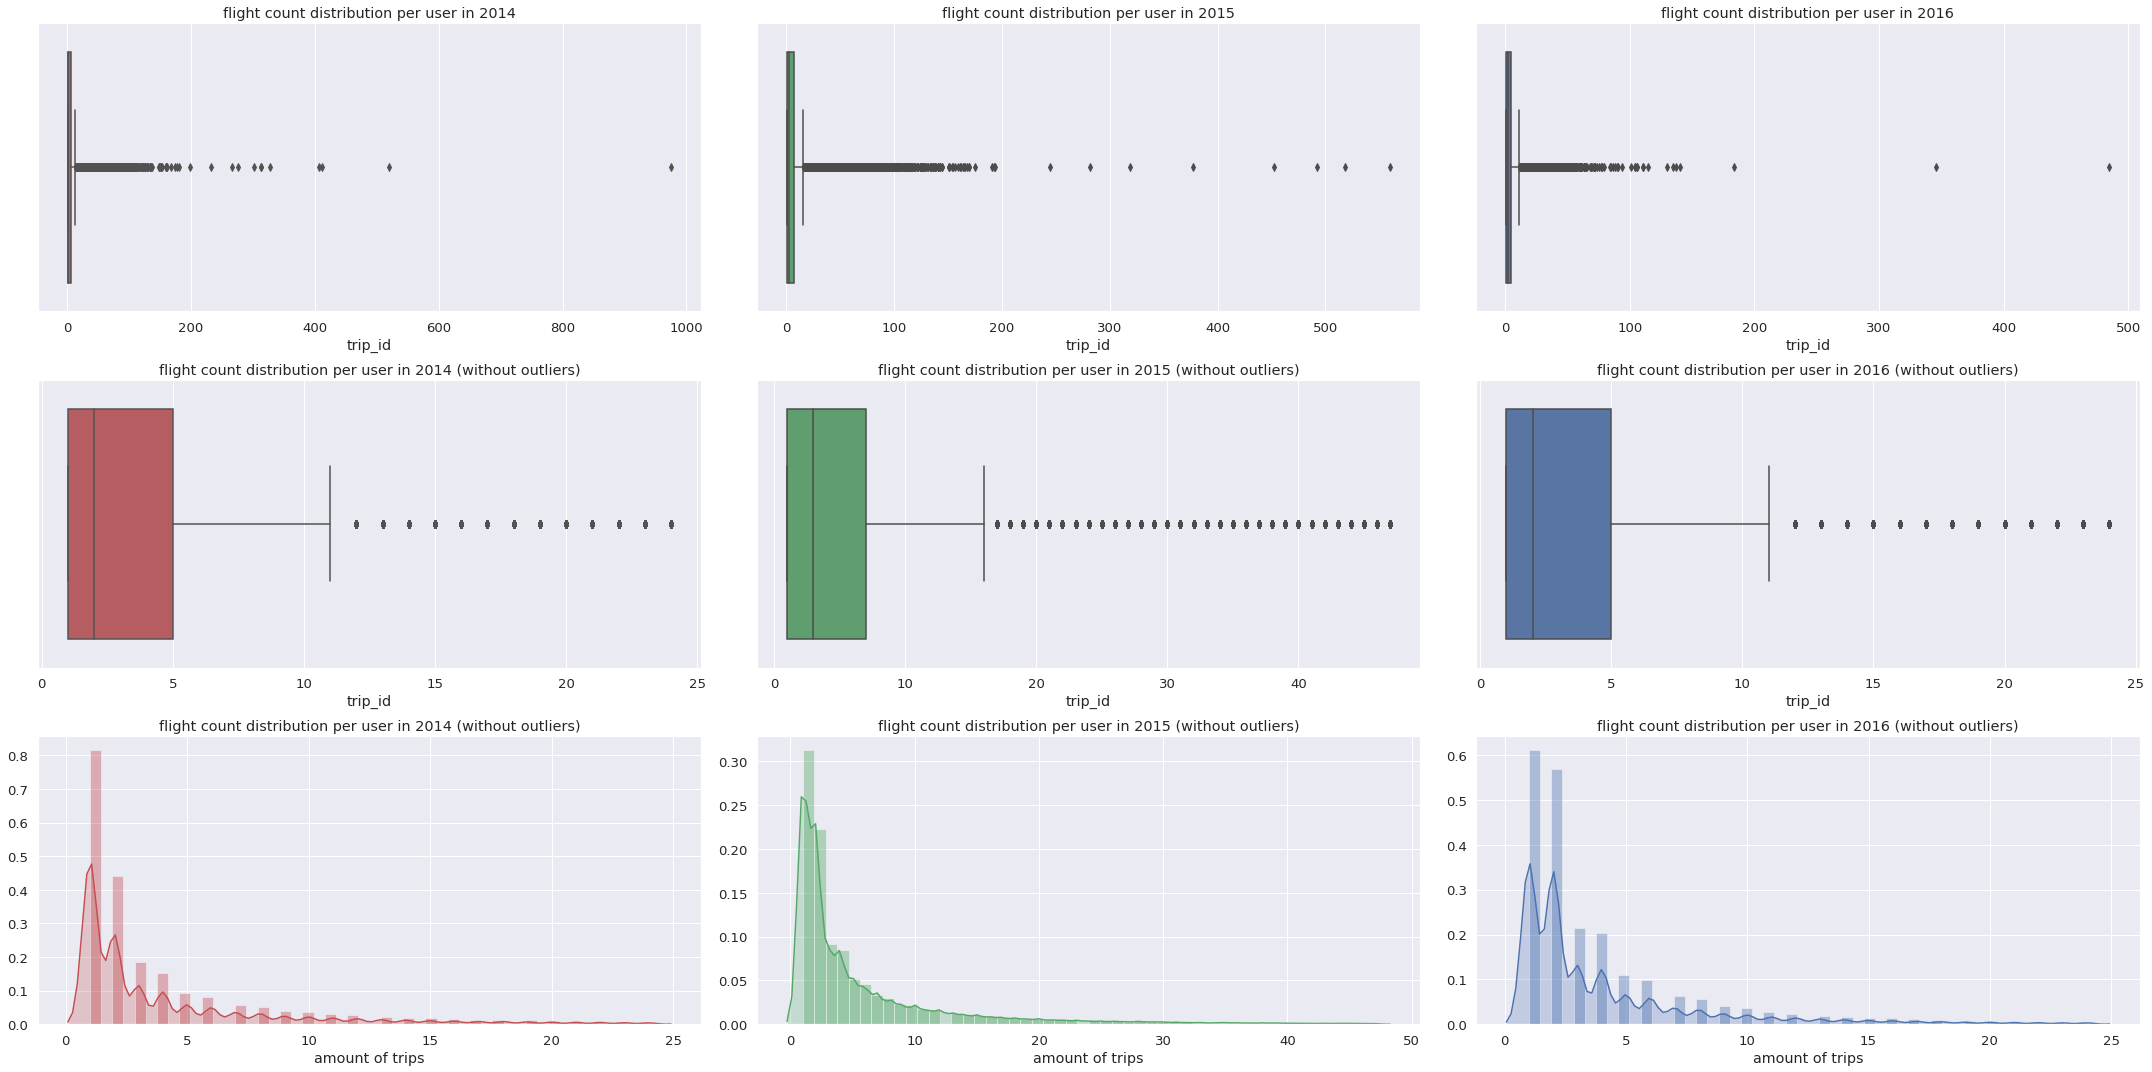

In [15]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(30,15))

ax[0][0].set_title('flight count distribution per user in 2014')
sns.boxplot(x=flights_amount_distribution_2014_wo, color='r', ax=ax[0][0])

ax[0][1].set_title('flight count distribution per user in 2015')
sns.boxplot(x=flights_amount_distribution_2015_wo, color='g', ax=ax[0][1])

ax[0][2].set_title('flight count distribution per user in 2016')
sns.boxplot(x=flights_amount_distribution_2016_wo, color='b', ax=ax[0][2])

ax[1][0].set_title('flight count distribution per user in 2014 (without outliers)')
sns.boxplot(x=flights_amount_distribution_2014, color='r', ax=ax[1][0])

ax[1][1].set_title('flight count distribution per user in 2015 (without outliers)')
sns.boxplot(x=flights_amount_distribution_2015, color='g', ax=ax[1][1])

ax[1][2].set_title('flight count distribution per user in 2016 (without outliers)')
sns.boxplot(x=flights_amount_distribution_2016, color='b', ax=ax[1][2])

ax[2][0].set_title('flight count distribution per user in 2014 (without outliers)')
sns.distplot(flights_amount_distribution_2014, kde_kws={"shade": True}, color='r', axlabel='amount of trips', ax=ax[2][0])

ax[2][1].set_title('flight count distribution per user in 2015 (without outliers)')
sns.distplot(flights_amount_distribution_2015, kde_kws={"shade": True}, color='g', axlabel='amount of trips', ax=ax[2][1])

ax[2][2].set_title('flight count distribution per user in 2016 (without outliers)')
sns.distplot(flights_amount_distribution_2016, kde_kws={"shade": True}, color='b', axlabel='amount of trips', ax=ax[2][2])

fig.tight_layout()
plt.savefig(root_path + '/Colab Notebooks/aita_img/img2.png', bbox_inches='tight', pad_inches=1);

In [20]:
user_uniques = len(apptrip_sorted_df['user_id'].unique())
amount_of_rows = apptrip_sorted_df.shape[0]
print(f'amount_of_rows: {amount_of_rows}')
print(f'user_uniques: {user_uniques} ({user_uniques * 100 / amount_of_rows:0.2f}%)')

cities_unique = len(pd.unique(apptrip_sorted_df[['city_code_dep', 'city_code_arr']].values.ravel()))
print(f'cities_unique: {cities_unique} ({cities_unique * 100 / amount_of_rows:0.2f}%)')

amount_of_rows: 2346386
user_uniques: 258748 (11.03%)
cities_unique: 628 (0.03%)


Статистика полётов случайно выбранного пользователя

In [0]:
def build_random_user_flight_map(df):
  """
  Строит ориентированный мультиграф перемещений случайно выбранного пользователя
  
  Arguments:
  ----------
    df (DataFrame) : Датафрейм pandas с данными для работы
    
  Returns:
  --------
    int : Идентификатор пользователя
  """
  user_ids = df['user_id'].unique()
  
  edges = []
  cur_user = 0
  while (len(edges) < 10):
    cur_user = user_ids[random.randint(0, user_ids.shape[0])]
#     cur_user = 11275792564899860442
    edges = df[df['user_id'] == cur_user][['city_code_dep', 'city_code_arr']].values
  nodes = np.unique(edges)
  
  edge_list = [[x[0], x[1]] for x in edges]
  a, b = np.unique(edge_list, axis=0, return_counts=True)
  dir_edges = list(map(lambda x: (x[0][0], x[0][1], {'flights': x[1]}), zip(a, b)))
  
  g = nx.MultiDiGraph()
  g.add_nodes_from(nodes)
  g.add_edges_from(dir_edges)
  
  crs = ccrs.PlateCarree()
  pos = {city: city_coords_dict[city] for city in nodes}
  edge_labels = dict([((u,v,), d['flights']) for u,v,d in g.edges(data=True)])
  
  sizes = np.zeros(len(nodes))
  for i, node in enumerate(g.nodes):
    for edge, flights in edge_labels.items():
      if edge[1] == node:
        sizes[i] += flights
  sizes *= 300
  sizes += 50
  
  deg = nx.degree(g)
  colors = [degree[1] for degree in deg]
  
  pos_higher = {}
  x_offset = 10
  for k, v in pos.items():
    pos_higher[k] = (v[0] - x_offset, v[1])
  
  fig, ax = plt.subplots(1, 1, figsize=(20, 10), subplot_kw=dict(projection=crs))
  ax.coastlines()
  ax.set_extent([-180., 180., -90., 90.], crs=crs)
  ax.background_patch.set_visible(False)
  
  nx.draw_networkx_nodes(g, pos, ax=ax, node_size=sizes, node_color=colors, cmap='Spectral_r', alpha=.75)
  nx.draw_networkx_labels(g, pos_higher, font_size=21)
  nx.draw_networkx_edges(g, pos, ax=ax, arrowsize=20)
  nx.draw_networkx_edge_labels(g, pos, ax=ax, edge_labels=edge_labels, label_pos=0.35, font_size=16)
  
  plt.savefig(root_path + '/Colab Notebooks/aita_img/img3.png', bbox_inches='tight', pad_inches=1);
  
  print(f'cur_user: {cur_user}')
  
  return cur_user

cur_user: 4869604337293580773


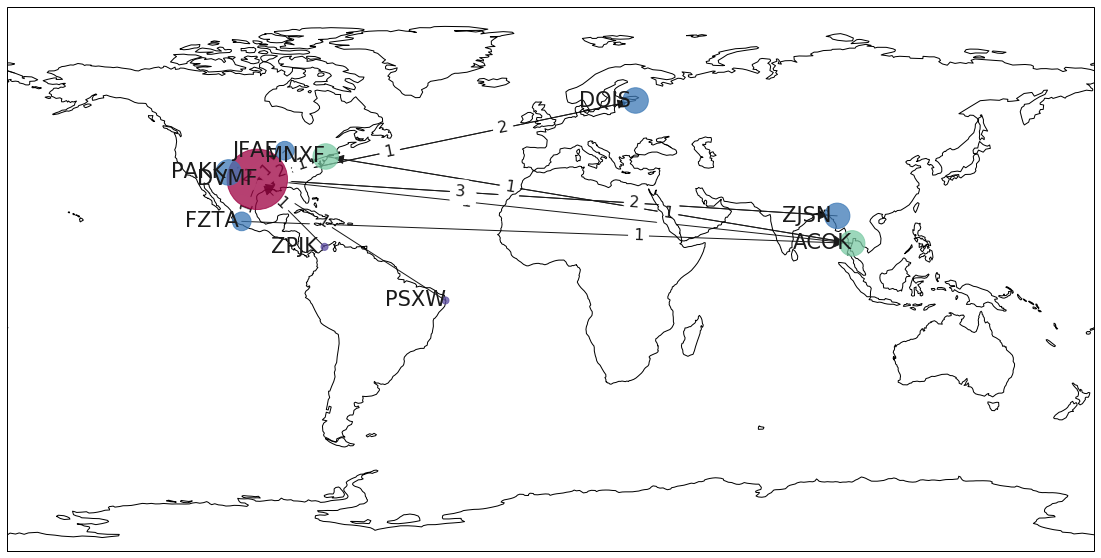

In [17]:
current_user = build_random_user_flight_map(apptrip_sorted_df)

In [0]:
flight_behaviour_2014 = year_2014.copy()
flight_behaviour_2014['departure_month_utc'] = months_2014
flight_behaviour_2014 = pd.DataFrame(flight_behaviour_2014[flight_behaviour_2014['user_id']==current_user].groupby('departure_month_utc')['trip_id'].count())
flight_behaviour_2014 = flight_behaviour_2014.reset_index()

flight_behaviour_2015 = year_2015.copy()
flight_behaviour_2015['departure_month_utc'] = months_2015
flight_behaviour_2015 = pd.DataFrame(flight_behaviour_2015[flight_behaviour_2015['user_id']==current_user].groupby('departure_month_utc')['trip_id'].count())
flight_behaviour_2015 = flight_behaviour_2015.reset_index()

flight_behaviour_2016 = year_2016.copy()
flight_behaviour_2016['departure_month_utc'] = months_2016
flight_behaviour_2016 = pd.DataFrame(flight_behaviour_2016[flight_behaviour_2016['user_id']==current_user].groupby('departure_month_utc')['trip_id'].count())
flight_behaviour_2016 = flight_behaviour_2016.reset_index()

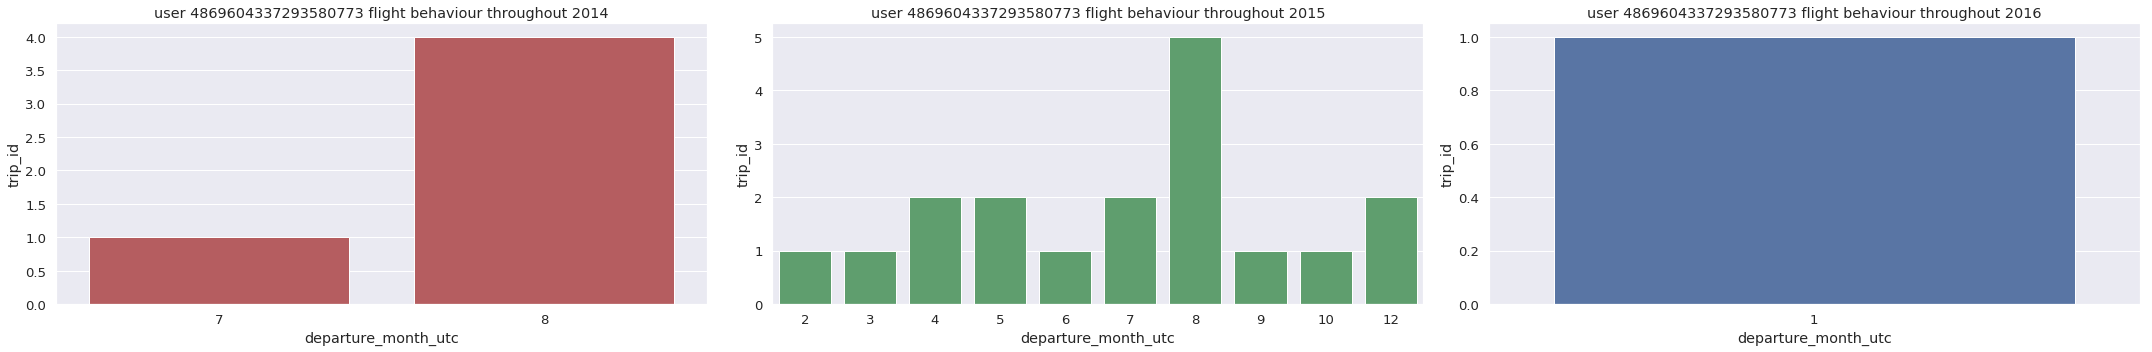

In [19]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(30,5))

ax[0].set_title(f'user {current_user} flight behaviour throughout 2014')
sns.barplot(x="departure_month_utc", y='trip_id', data=flight_behaviour_2014, color='r', ax=ax[0])

ax[1].set_title(f'user {current_user} flight behaviour throughout 2015')
sns.barplot(x="departure_month_utc", y='trip_id', data=flight_behaviour_2015, color='g', ax=ax[1])

ax[2].set_title(f'user {current_user} flight behaviour throughout 2016')
sns.barplot(x="departure_month_utc", y='trip_id', data=flight_behaviour_2016, color='b', ax=ax[2])

fig.tight_layout()
plt.savefig(root_path + '/Colab Notebooks/aita_img/img4.png', bbox_inches='tight', pad_inches=1);

# Hidden Markov Model

Для предсказания следующего города, в который может отправиться пользователь, будем использовать HMM. Будем оценивать оптимальную последовательность hidden states, чтобы в конечном итоге выйти на предсказание следующей поездки пользователя.

В качестве алгоритма декодирования выберем Viterbi Algorithm.

In [0]:
def viterbi(pi, tran, emis, obs, cities_to_array):
  """
  Имплементация алгоритма Viterbi для нахождения наиболее вероятной последовательности городов
  
  Arguments:
  ----------
    pi (numpy array)       : Датафрейм pandas с данными для работы
    tran (numpy 2d array)  : transition matrix - матрица переходов для всех возможных городов
    emis (numpy 2d array)  : emission matrix - матрица состояний, по строкам располагаются все города,
                             по столбцбам - все пункты назначения пользователя
    obs (numpy array)      : observations - последовательность пунктов назначения пользователя
    cities_to_array (list) : список городов, в которых пользователь побывал
    
  Returns:
  --------
    numpy array: Массив, содержащий все последующие пункты назначения после текущего для каждого элемента
                 из obs
    list       : Топ 5 возможных городов для последнего элемента obs
  """
  nStates = np.shape(emis)[0]
  T = np.shape(obs)[0]

  path = np.zeros(T, dtype=int)
  delta = np.zeros((nStates, T))
  phi = np.zeros((nStates, T))

  delta[:, 0] = pi * emis[:, cities_to_array.index(obs[0])]
  phi[:, 0] = 0

  for t in range(1, T):
    for s in range(nStates):
      delta[s, t] = np.max(delta[:, t - 1] * tran[:, s]) * emis[s, cities_to_array.index(obs[t])] 
      phi[s, t] = np.argmax(delta[:, t - 1] * tran[:, s])

  path[T - 1] = np.argmax(delta[:, T - 1])
  top5 = np.argsort(delta[:, T - 1])[-5:]
  
  for t in range(T - 2, -1, -1):
      path[t] = phi[path[t + 1], [t + 1]]    
  return path, top5

В ходе вычислений было принято решение рассматривать каждого пользователя отдельно, без опоры на кластеры по схожим паттернам путешествия. Поэтому в качестве hidden states выбираем все возможные города для перелёта. За observable state примем города-destination пользователя. Строить модель будем по массиву observations -- города-destinations в хронологическом порядке.

Оптимальное значение параметра **p_thresh** на данный момент равно 0.83.

In [0]:
def calc_user_accuracy(df, all_cities, p_thresh=0.9):
  user_ids = df['user_id'].unique()
  cur_user = 0
  entries = np.asarray([])
  while entries.shape[0] < 2:
    cur_user = np.random.choice(user_ids, 1)[0]
#     cur_user = 11275792564899860442
    entries = df[df['user_id'] == cur_user]
  entries.drop(['flight_id', 'km', 'departure_code', 'arrival_code', 'carrier', 'number', 'carrier_operating', 'parent_carrier_operating'], axis=1, inplace=True)
#   print(f'user {cur_user}')

  test_trip = entries.iloc[-1,:]
  entries.drop(entries.tail(1).index, inplace=True)
  
  all_cities_len = all_cities.shape[0]
  cities_from = Counter(entries['city_code_dep'].values)
  cities_to = Counter(entries['city_code_arr'].values)
  trips = Counter(entries[['city_code_dep', 'city_code_arr']].apply(lambda x: (x[0], x[1]), axis=1))
  transition_matrix = np.full((all_cities.shape[0], all_cities.shape[0]), 1 / all_cities.shape[0])
  for i in range(transition_matrix.shape[0]):
    if all_cities[i] in cities_from:
      for j in range(transition_matrix.shape[1]):
        if all_cities[j] in cities_to:
          probability = trips[(all_cities[i], all_cities[j])] / cities_from[all_cities[i]]
          transition_matrix[i][j] = p_thresh * probability
        else:
          probability = 1 / (all_cities_len - len(cities_to))
          transition_matrix[i][j] = (1 - p_thresh) * probability
  #   display(pd.DataFrame(transition_matrix, index=all_cities, columns=all_cities))
  
  cities_to_array = list(cities_to.keys())
  emission_matrix = np.full((all_cities.shape[0], len(cities_to)), 1 / len(cities_to))
  for i in range(emission_matrix.shape[0]):
    if (all_cities[i] in cities_from.keys()):
      for j in range(emission_matrix.shape[1]):
        probability = trips[(all_cities[i], cities_to_array[j])] / cities_from[all_cities[i]]
        emission_matrix[i][j] = probability
#   display(pd.DataFrame(emission_matrix, index=all_cities, columns=cities_to_array))
  
  observations = entries['city_code_arr'].values
  pi = [cities_to[x] / sum(cities_to.values()) if x in cities_to.keys() else 1/(all_cities_len - len(cities_to)) for x in all_cities]
  
  path, top5 = viterbi(pi, transition_matrix, emission_matrix, observations, cities_to_array)
#   print(f'observation: {observations}')
#   print(f'best path: {path}')
  
  pred = all_cities[path[-1]]
  true = test_trip['city_code_arr']
  
  return cur_user, pred, true, all_cities[top5][::-1]

Так как мы строим предсказание для конкретного пользователя независимо от остальных, то возьмём выборку из $\leqslant$ 5000  пользователей и проверим на них качество предсказания.

In [24]:
N = 5000
users = np.zeros((N))
preds = [''] * N
trues = [''] * N
top5  = [[]] * N
for i in tqdm_notebook(range(N)):
  users[i], preds[i], trues[i], top5[i] = calc_user_accuracy(apptrip_sorted_df, cities, p_thresh=0.83)

## Значения метрик

В итоге получаем, что для трети пользователей предсказание без учета топ 5 результатов выполняется успешно.

In [28]:
user_scores_df = pd.DataFrame().assign(user_id=users).assign(pred=preds).assign(true=trues).assign(top5=top5)
display(user_scores_df)

true_prediction = user_scores_df[user_scores_df['pred'] == user_scores_df['true']]['user_id'].values
print(f'accuracy: {true_prediction.shape[0]} ({true_prediction.shape[0] * 100 / N:.2f}%)')

# f1_w = metrics.f1_score(user_scores_df['true'], user_scores_df['pred'], average='weighted')
# recall_w = metrics.recall_score(user_scores_df['true'], user_scores_df['pred'], average='weighted')

# print(f'f1_score (weighted): {f1_w:.3f}')
# print(f'recall (weighted): {recall_w:.3f}')

,user_id,pred,true,top5
0,3.346503e+18,ZJSN,SJXB,"[ZJSN, FQOO, YWBT, DYVE, MRZB]"
1,1.167036e+19,KFPS,KFPS,"[KFPS, EVNK, NWVK, CVQB, YWBT]"
2,1.157903e+19,RLVR,RLVR,"[RLVR, EVNK, LKOT, NWVK, IIOP]"
...,...,...,...,...
4997,3.252975e+18,WAOU,WAOU,"[WAOU, EVNK, FQOO, YWBT, DYVE]"
4998,1.422764e+19,MNXF,PAKK,"[MNXF, EVNK, UQHA, DYVE, MRZB]"
4999,2.529308e+18,PSXW,NUDA,"[PSXW, TEYH, MNXF, EVNK, FJXS]"


accuracy: 1678 (33.56%)


В то же время, точность при предсказании 5 результатов увеличивается на 5-10%.

In [29]:
top5_df = user_scores_df[user_scores_df.apply(lambda x: x['true'] in x['top5'], axis=1)]
print(f'top5 accuracy: {top5_df.shape[0] * 100 / N:.2f}%')

top5 accuracy: 39.24%


Тогда рассмотрим набор пользователей, для которых предсказание без учёта топ5 прошло успешно. Составим для них новый датафрейм с признаками: user_id, top_carrier, amount_of_trips.

In [50]:
true_df = pd.DataFrame()
for id in true_prediction:
  true_df = pd.concat([true_df, apptrip_sorted_df[apptrip_sorted_df['user_id'] == id]])
true_df.drop(['flight_id', 'departure_utc', 'arrival_utc'], axis=1, inplace=True)
display(true_df)

user_top_carrier_dict = dict(true_df.groupby('user_id').apply(lambda x: x['carrier'].value_counts().index[0]))

chosen_users_df = pd.DataFrame(true_df['user_id'].unique().ravel(), columns=['user_id'])
chosen_users_df = chosen_users_df.sort_values('user_id')
chosen_users_df['top_carrier_le'] = [user_top_carrier_dict[user] for user in chosen_users_df['user_id']]
chosen_users_df['top_carrier_le'] = preprocessing.LabelEncoder().fit_transform(chosen_users_df['top_carrier_le'].values)
chosen_users_df['amount_of_trips'] = true_df.groupby('user_id')['trip_id'].count().ravel()
chosen_users_df.set_index('user_id', inplace=True)
display(chosen_users_df)

,user_id,trip_id,km,departure_code,arrival_code,carrier,number,carrier_operating,parent_carrier_operating,city_code_dep,city_code_arr
337857,11670355246763192213,9677194106728555613,11493343,CZVUD,IOSWI,ZLG,1721.0,ZLG,ZLG,ACOK,KFPS
378997,11670355246763192213,7774101774910202471,2890561,IOSWI,PNKOQ,ZLG,2934.0,ZLG,ZLG,KFPS,WAOU
388909,11670355246763192213,12845907071849860345,2726511,MCHYK,IOSWI,ZLG,2329.0,ZLG,ZLG,GGTV,KFPS
...,...,...,...,...,...,...,...,...,...,...,...
1721821,3252975246201773989,10601549809970060962,3221942,AMNXA,PNKOQ,GWL,1125.0,GWL,GWL,ZPJK,WAOU
1760630,3252975246201773989,14029899239048809755,1496136,FRHBT,FLIIX,WDL,6131.0,IJK,GWL,WAOU,KJQC
1773378,3252975246201773989,9047521941136791014,3221942,AMNXA,PNKOQ,GWL,1108.0,GWL,GWL,ZPJK,WAOU


,top_carrier_le,amount_of_trips
user_id,,
1474466562692411,30,9
15050865446817593,30,11
32468195454433037,24,19
...,...,...
18421076379793095218,26,85
18423357110416255097,4,5
18435118662736866888,30,43


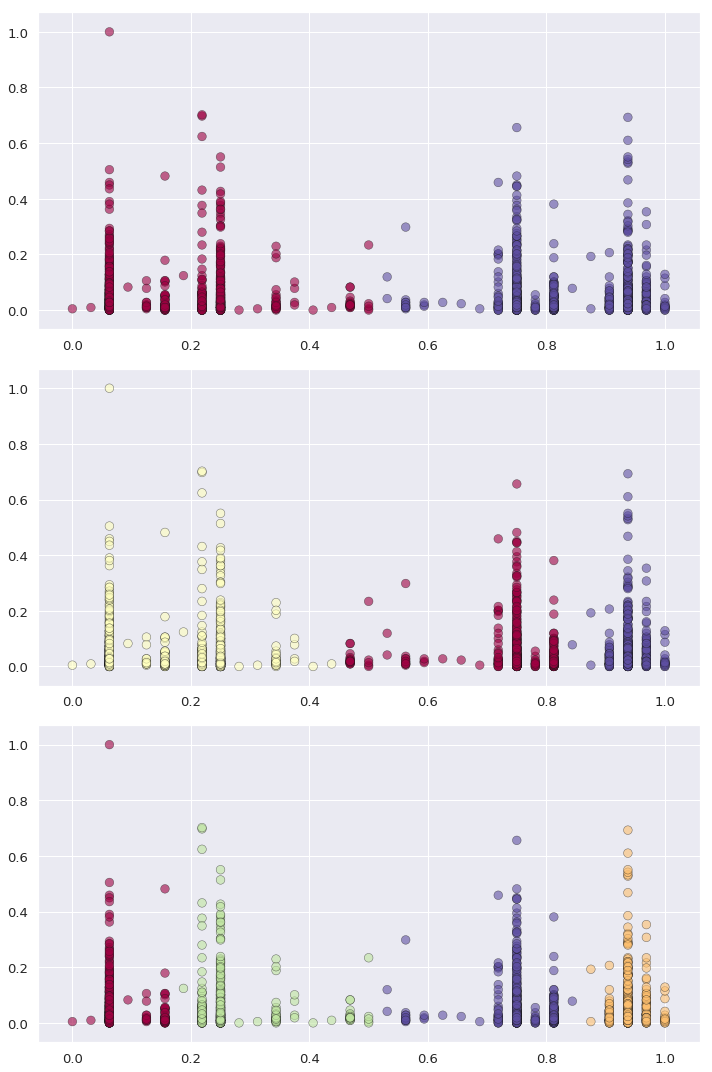

In [78]:
chosen_users_df_std = preprocessing.MinMaxScaler().fit_transform(chosen_users_df)
chosen_users_df_std = pd.DataFrame(chosen_users_df_std, columns=chosen_users_df.columns)

clust_count = 3

fig, ax = plt.subplots(3,1,figsize=(10, 15))

for i in range(clust_count):
  kmeans_model = KMeans(n_clusters=i + 2, random_state=np.random.randint(0, 100))    
  labels = kmeans_model.fit_predict(chosen_users_df_std);

  ax[i].scatter(chosen_users_df_std.iloc[:,0], chosen_users_df_std.iloc[:,1],
                                 s=75, alpha=.6, edgecolor='k', linewidth=.5,
                                 c=labels, cmap=plt.cm.get_cmap('Spectral'))

fig.tight_layout();
plt.savefig(root_path + '/Colab Notebooks/aita_img/img5.png', bbox_inches='tight', pad_inches=1);

Из результатов можно сделать вывод, что можно попробовать искать перекрестную зависимость между признаками пользователей.

# Classification

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

Для классификации рассмотрим данные за 2015 год. Посчитаем простую модель для поверхностного сравнения качества.

In [81]:
df_class = year_2015.drop(['trip_id', 'flight_id', 'departure_code', 'arrival_code', 'departure_utc', 'arrival_utc', 'parent_carrier_operating', 'carrier_operating', 'km', 'number'], axis=1)
df_class

,user_id,carrier,city_code_dep,city_code_arr
0,174609662417983272,WDL,WAOU,DVMF
1,2536326491249154417,FYA,TWJT,RYMM
2,12521801051667925288,WDL,PAKK,TJLJ
...,...,...,...,...
1131762,8709750218978068612,ZQR,DVMF,ZJSN
1131763,12596271478475780664,BZM,DVMF,ZJSN
1131764,15683215970308098933,QIA,BPTU,HJOE


Data preprocessing

In [82]:
le = preprocessing.LabelEncoder()
df_class['carrier'] = le.fit_transform(df_class['carrier'])

le_2 = preprocessing.LabelEncoder()
df_class['city_code_dep'] = le_2.fit_transform(df_class['city_code_dep'].apply(str))

le_3 = preprocessing.LabelEncoder()
df_class['city_code_arr'] = le_3.fit_transform(df_class['city_code_arr'].apply(str))

df_class['date'] = year_2015['departure_utc'].map(lambda x: x.month)

df_class

,user_id,carrier,city_code_dep,city_code_arr,date
0,174609662417983272,138,476,69,1
1,2536326491249154417,35,426,373,1
2,12521801051667925288,138,318,412,1
...,...,...,...,...,...
1131762,8709750218978068612,172,73,538,12
1131763,12596271478475780664,16,73,538,12
1131764,15683215970308098933,100,32,144,12


Рассмотрим матрицу корелляций. Явной зависимости между выбранными признаками нет, поэтому дальше данные можно не изменять

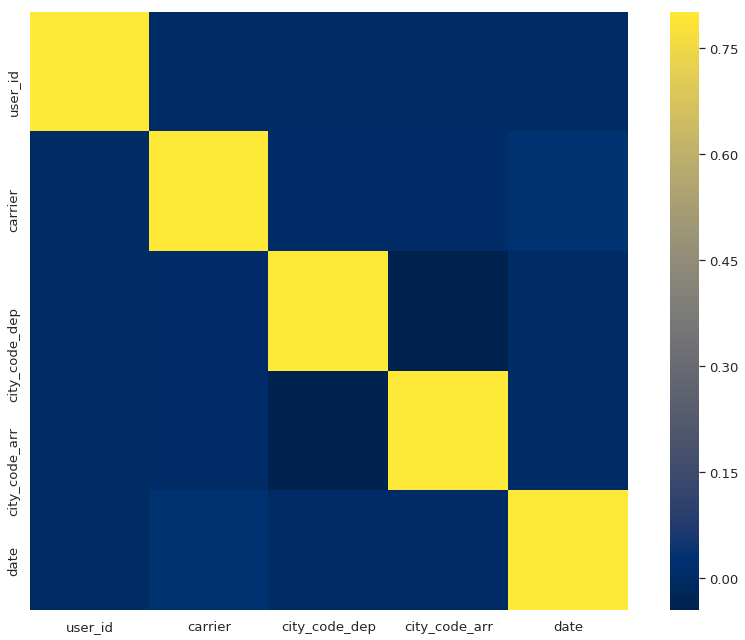

In [83]:
corr = df_class.corr()
plt.figure(figsize=(15, 11))
sns.heatmap(corr, vmax=.8, square=True, cmap='cividis');

In [0]:
df_class = df_class[:int(df_class.shape[0] * 0.05)]
y = df_class['city_code_arr']
df_class = df_class.drop(['city_code_arr'], axis=1)

Определим границу разделения данных

In [0]:
border = int(df_class.shape[0] * 0.7)

x_train, x_test = df_class[:border], df_class[-border:]
y_train, y_test = y[:border], y[-border:]

In [0]:
clf = XGBClassifier()

clf.fit(x_train, y_train)
res = clf.predict(x_test)

Посчитаем метрики

In [88]:
accuracy = metrics.accuracy_score(y_test, res)
f1_w = metrics.f1_score(y_test, res, average='weighted')
recall_w = metrics.recall_score(y_test, res, average='weighted')

print(f'accuracy: {accuracy:.3f}')
print(f'f1_score (weighted): {f1_w:.3f}')
print(f'recall (weighted): {recall_w:.3f}')

accuracy: 0.227
f1_score (weighted): 0.173
recall (weighted): 0.227
